In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
from importlib import reload
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')


Welcome to JupyROOT 6.24/06
Success


## Reading in files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":10,
          "Load_standard":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":False,
          "Load_pi0_signal":False} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

In [3]:
signal_samples_dict = {}

if Params["Load_pi0_signal"] == False:
    Presel_overlay = pd.read_pickle(loc_pkls+"Preselected_overlay_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
    if Params["Load_single_file"] == True:
        HNL_mass = Params["single_file"]
        Presel_signal = pd.read_pickle(loc_pkls+f"Preselected_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
        signal_samples_dict[HNL_mass] = Presel_signal
    else:
        for HNL_mass in Constants.HNL_mass_samples:
            Presel_signal = pd.read_pickle(loc_pkls+f"Preselected_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
            signal_samples_dict[HNL_mass] = Presel_signal
    
if Params["Load_pi0_signal"] == True:
    Presel_overlay = pd.read_pickle(loc_pkls+"pi0_selection/Preselected_"+Params["Run"]+"_overlay_ultimate.pkl")
    
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        Presel_signal = pd.read_pickle(loc_pkls+f"pi0_selection/Preselected_"+Params["Run"]+f"_{HNL_mass}_pi0_ultimate.pkl")
        signal_samples_dict[HNL_mass] = Presel_signal
    
if Params["EXT_in_training"] == True:
    Presel_EXT = pd.read_pickle(loc_pkls+"Preselected_EXT_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")

print(Presel_overlay.keys())

Index(['run', 'sub', 'evt', 'nslice', 'n_pfps', 'n_tracks', 'n_showers',
       'swtrig_pre', 'swtrig_post', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_theta_v', 'shr_phi_v', 'shr_px_v', 'shr_py_v',
       'shr_pz_v', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2',
       'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_x_v',
       'trk_dir_y_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_hits_tot',
       'trk_energy_tot', 'trk_score_v', 'trk_calo_energy_u_v', 'trk_end_x_v',
       'trk_chipr_best', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'NeutrinoEnergy2', 'SliceCaloEnergy2', 'nu_flashmatch_score',
       'contained_sps_ratio', 'flash_time', 'contained_fraction', 'trk_score',
       'crtveto', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight',
       'min_x', 'max_x', 'min_y', 'max_y', 'min_z', 'max_z', 'highest_E'],
      dtype='object')


## Splitting into test and training samples

In [4]:
ultimate_feature_list = ['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot',
                         'trk_theta_v', 'trk_phi_v','trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_calo_energy_u_v', 'trk_score_v',
                         'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2', 'nu_flashmatch_score']
print(f"Number of features is {len(ultimate_feature_list)}")

bdt_vars = ultimate_feature_list #This is using just the most important variables list

new_value = -9999 #This tells XGB what number refers to missing data for all variables

signal_train_dict = {}
signal_test_dict = {}
labels_dict = {} 

train_vs_test_fraction = 0.7 #This is the fraction used for training

print(f"Total length of overlay file is {len(Presel_overlay)}")

overlay_train = Presel_overlay[:int(len(Presel_overlay)*train_vs_test_fraction)]
overlay_test = Presel_overlay[int(len(Presel_overlay)*train_vs_test_fraction):]

print(f"Total length of overlay TRAIN file is {len(overlay_train)}")
print(f"Total length of overlay TEST file is {len(overlay_test)}")

# overlay_train = Presel_overlay[int(len(Presel_overlay)*train_vs_test_fraction):] #OLD WRONG WAY, i.e 70% test
# overlay_test = Presel_overlay[:int(len(Presel_overlay)*train_vs_test_fraction)]

Number of features is 19
Total length of overlay file is 44111
Total length of overlay TRAIN file is 30877
Total length of overlay TEST file is 13234


In [5]:
pickle_files = False

if Params["Load_pi0_signal"] == False:
    overlay_test.to_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
    
    for HNL_mass in signal_samples_dict:
        signal_train_dict[HNL_mass] = signal_samples_dict[HNL_mass][:int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction)]
        signal_test_dict[HNL_mass] = signal_samples_dict[HNL_mass][int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction):]
        if pickle_files == True:
            print(f"Pickling {HNL_mass}MeV HNL test sample")
            signal_test_dict[HNL_mass].to_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
    
        labels_dict[HNL_mass] = [1]*len(signal_train_dict[HNL_mass][bdt_vars]) + [0]*len(overlay_train[bdt_vars])
if Params["Load_pi0_signal"] == True:
    overlay_test.to_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+"_ultimate.pkl")

    for HNL_mass in signal_samples_dict:
        signal_train_dict[HNL_mass] = signal_samples_dict[HNL_mass][:int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction)]
        signal_test_dict[HNL_mass] = signal_samples_dict[HNL_mass][int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction):]
        if pickle_files == True:
            print(f"Pickling {HNL_mass}MeV HNL pi0 test sample")
            signal_test_dict[HNL_mass].to_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{HNL_mass}_pi0_"+
                                                 Params["Run"]+"_ultimate.pkl")
    
        labels_dict[HNL_mass] = [1]*len(signal_train_dict[HNL_mass][bdt_vars]) + [0]*len(overlay_train[bdt_vars])
    
if Params["EXT_in_training"] == True:
    frac_EXT = 0.1
    EXT_train = Presel_EXT[:int(len(Presel_EXT)*frac_EXT)]
    print("Number of EXT to train: " + str(len(EXT_train)))
    overlay_plus_EXT = pd.concat([overlay_train[bdt_vars],EXT_train[bdt_vars]])
    for HNL_mass in Constants.HNL_mass_samples:
        labels_dict[HNL_mass] = labels_dict[HNL_mass] + [0]*len(EXT_train[bdt_vars])

## BDT Training

In [6]:
xgb_train_dict = {}
xgb_test_dict = {}

xgb_sig_train_dict = {}
xgb_bkg_train_dict = {}

xgb_test_bkg = xgboost.DMatrix(overlay_test[bdt_vars], label=[0]*len(overlay_test[bdt_vars]), missing=new_value, feature_names=bdt_vars)

xgb_param = {'booster': 'dart',
        'max_depth':6,
        'eta':0.3,
        'objective':'binary:logistic',
#        'eval_metric':'auc', 
#        'subsample':0.5,
        'tree_method':'hist',
#        'scale_pos_weight': float(len(data_bkg_train))/float(len(data_sig_train)),
        'rate_drop': 0.1,
        'skip_drop': 0.5 }
num_round = 200
progress = dict()

for HNL_mass in signal_train_dict:
    if Params["EXT_in_training"] == False:
        xgb_train_dict[HNL_mass] = xgboost.DMatrix(pd.concat([signal_train_dict[HNL_mass][bdt_vars], #This is both signal and bkg combined into one
                                                               overlay_train[bdt_vars]]), 
                                               label=labels_dict[HNL_mass], 
                                                    missing=new_value, feature_names=bdt_vars)
    if Params["EXT_in_training"] == True:
        xgb_train_dict[HNL_mass] = xgboost.DMatrix(pd.concat([signal_train_dict[HNL_mass][bdt_vars], #This is both signal and bkg combined into one
                                                               overlay_plus_EXT[bdt_vars]]), 
                                               label=labels_dict[HNL_mass], 
                                                    missing=new_value, feature_names=bdt_vars)
    xgb_test_dict[HNL_mass] = xgboost.DMatrix(signal_test_dict[HNL_mass][bdt_vars], label=[1]*len(signal_test_dict[HNL_mass][bdt_vars]), #Just signal test
                                              missing=new_value, feature_names=bdt_vars)
    
    xgb_sig_train_dict[HNL_mass] = xgboost.DMatrix(signal_train_dict[HNL_mass][bdt_vars],label=[1]*len(signal_train_dict[HNL_mass][bdt_vars]), #Signal training
                                                  missing=new_value, feature_names=bdt_vars)
    xgb_bkg_train_dict[HNL_mass] = xgboost.DMatrix(overlay_train[bdt_vars],label=[0]*len(overlay_train[bdt_vars]), #Just background training
                                                  missing=new_value, feature_names=bdt_vars)

    #watchlist so that you can monitor the performance of the training by iterations
    watchlist = [(xgb_train_dict[HNL_mass], 'train'), (xgb_test_dict[HNL_mass], 'test_sig'), (xgb_test_bkg,'test_bkg')]

In [7]:
BDT_name = "ultimate_benchmark_plus_flashmatch"

for HNL_mass in signal_train_dict:
    print(f"Training {HNL_mass}MeV BDT" + "\n")
    bdt = xgboost.train(xgb_param, xgb_train_dict[HNL_mass], num_round, watchlist, evals_result=progress, verbose_eval=False)
    # doesnt like watchlist/eval_result if using AOC
    # save model so you can load it later
    if Params["Load_pi0_signal"] == False:
        bdt.save_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
    if Params["Load_pi0_signal"] == True:
        bdt.save_model("bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}MeV_pi0_{BDT_name}.json")
    

Training 2MeV BDT

[10:50:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training 10MeV BDT

[10:51:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training 20MeV BDT

[10:52:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd 

In [ ]:
var_list = bdt_vars

# BDT_name = "New_20_variables_FIXED"

with open("bdts/input_vars/"+BDT_name, "wb") as fp:   #Pickling
    pickle.dump(var_list, fp)

# with open("bdts/input_vars/"+BDT_name, "rb") as fp:   # Unpickling
#     b = pickle.load(fp)
    
# print(b)

# Finished Training

## Checking variable correlations

In [ ]:
bdt_vars = feature_names
HNL_mass = 20

In [ ]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:
method = 'kendall'
correlations = signal_samples_dict[HNL_mass][bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [ ]:
#Just looking at most correlated 
corr=signal_samples_dict[HNL_mass][bdt_vars].corr()
high_corr_var=np.where(corr>0.999)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
#high_corr_var
print("Done")

## Looking at feature importances

In [14]:
#Make an importances dict   
def Top_N_vars(bdt_model, N_vars):
    importance = bdt.get_score(importance_type="gain")
    # for key in importance.keys():
    #     importance[key] = round(importance[key],1)
    sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1]))
    sorted_importance_list = list(sorted_importance.values())
    sorted_importance_keys= list(sorted_importance.keys())
    top_N = sorted_importance_keys[-N_vars:]
    
    return top_N

def Sorted_importance(bdt_model):
    importance = bdt.get_score(importance_type="gain")
    return importance

top_N_dict = {}
importance_dict = {}
list_of_lists = []
BDT_name = "ultimate_benchmark_plus_flashmatch"

for HNL_mass in Constants.HNL_mass_samples:
    bdt = xgboost.Booster()
    # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_ultimate.json")
    bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
    # print("Number of entries in top20 is " + str(len(Top_N_vars(bdt, 20))))
    # top_N_dict[HNL_mass] = Top_N_vars(bdt, 20)
    top_N = Top_N_vars(bdt, 50)
    top_N_dict[HNL_mass] = Top_N_vars(bdt, 50)
    list_of_lists.append(Top_N_vars(bdt, 50))
    importance_dict[HNL_mass] = Sorted_importance(bdt)
    
elements_in_all = list(set.intersection(*map(set, list_of_lists)))
print(len(elements_in_all))
print(elements_in_all)

19
['trk_calo_energy_u_v', 'trk_theta_v', 'shrclusdir2', 'trk_phi_v', 'shr_phi_v', 'pfnplanehits_Y', 'trk_dir_z_v', 'nu_flashmatch_score', 'shr_pz_v', 'shr_energy_tot', 'pfnplanehits_U', 'pfnplanehits_V', 'n_pfps', 'shr_theta_v', 'trk_energy', 'NeutrinoEnergy2', 'n_tracks', 'trk_score_v', 'trk_energy_tot']


In [5]:
print(top_N_dict[245])

['n_tracks', 'shr_pz_v', 'shr_theta_v', 'trk_energy_tot', 'shrclusdir2', 'shr_energy_tot', 'pfnplanehits_Y', 'pfnplanehits_V', 'shr_phi_v', 'trk_theta_v', 'trk_phi_v', 'trk_calo_energy_u_v', 'pfnplanehits_U', 'trk_dir_z_v', 'trk_score_v', 'nu_flashmatch_score', 'n_pfps', 'NeutrinoEnergy2', 'trk_energy']


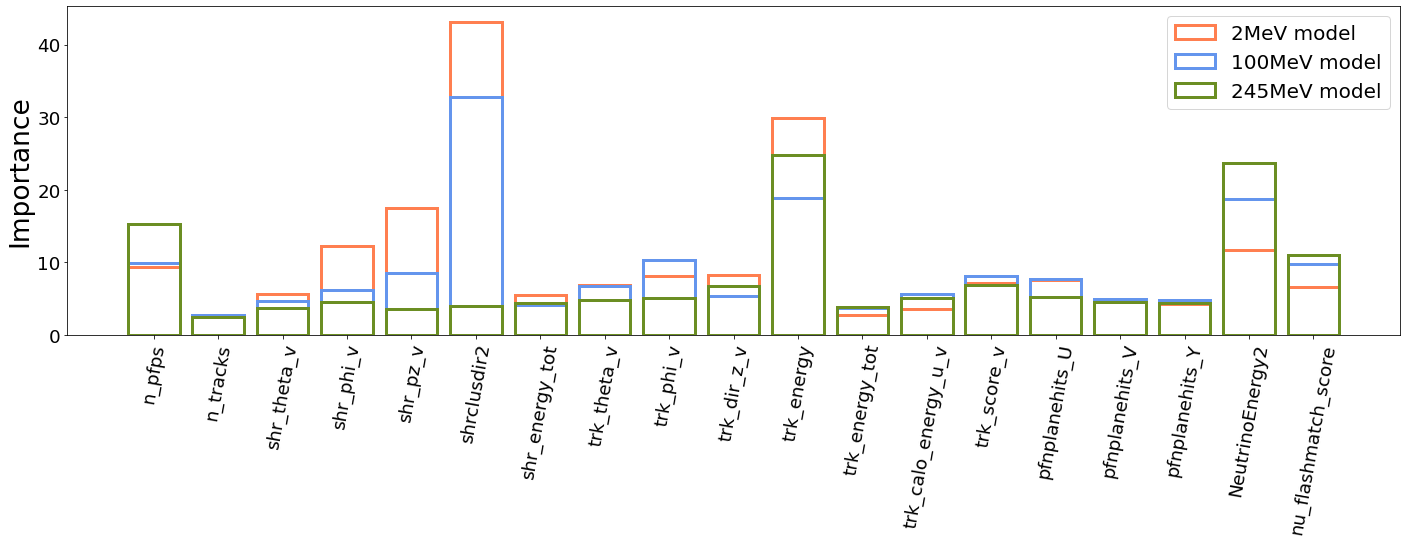

In [88]:
# for HNL_mass in Constants.HNL_mass_samples:
plt.figure(figsize=[20,8])
colours = {2:"coral", 100:"cornflowerblue", 245:"olivedrab"}
for HNL_mass in [2, 100, 245]:
    plt.bar(importance_dict[HNL_mass].keys(),importance_dict[HNL_mass].values(), label=f"{HNL_mass}MeV model", 
            fill=False,linewidth=3, edgecolor=colours[HNL_mass], color=colours[HNL_mass])
# plt.bar(importance_dict[245].keys(),importance_dict[245].values())
plt.xticks(np.array(range(0, len(importance_test.keys()))),importance_test.keys(),rotation=80)
plt.ylabel("Importance")
plt.legend(fontsize=20)
plt.tight_layout()

plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances_{BDT_name}.pdf")
plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances_{BDT_name}.png")

/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 0, 'Importance')

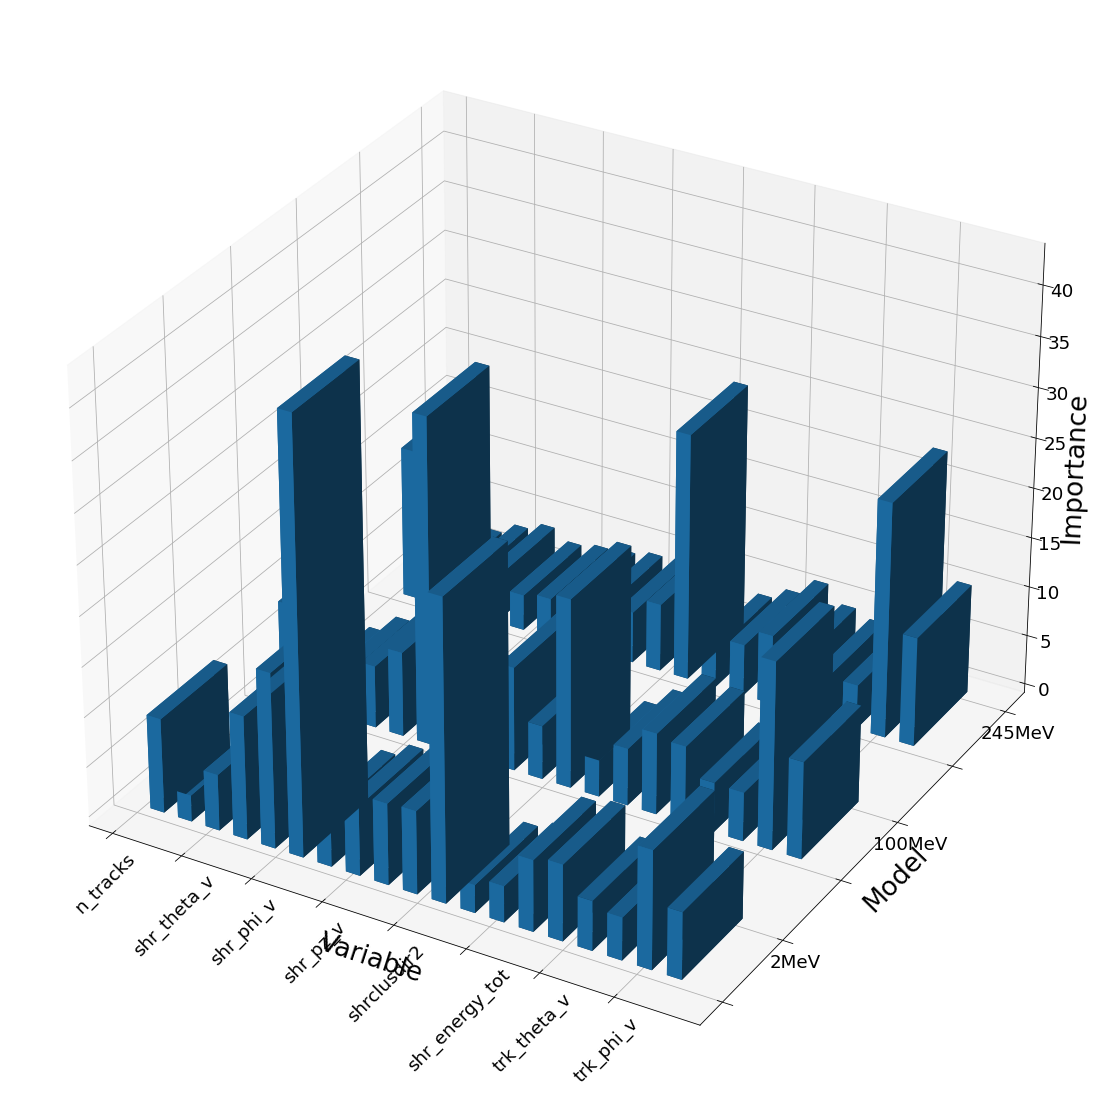

In [69]:
fig = plt.figure(figsize=[20,20])
ax1 = fig.add_subplot(projection='3d')

mass_list = ["2MeV", "100MeV", "245MeV"]
x = importance_dict[2].keys()
y = mass_list
data = np.array([list(importance_dict[2].values()),
                 list(importance_dict[100].values()),
                 list(importance_dict[245].values())])

numOfCols = len(x)
numOfRows = len(y)

xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = data.flatten()

mass_list_labels = [" "," ", "2MeV"," ", "100MeV"," ", "245MeV"]

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz)
ax1.set_xticklabels(list(importance_dict[2].keys()),rotation=45)
# ax1.set_xticklabels(list(importance_dict[2].keys()))
ax1.set_yticklabels(mass_list_labels)

ax1.set_xlabel('Variable')
ax1.set_ylabel('Model')
ax1.set_zlabel('Importance')
# plt.show()

# Finished code

In [ ]:
xgb_test_dict.keys()

In [ ]:
# dirt_matrix = xgboost.DMatrix(dirt_BDT[bdt_vars])
# EXT_matrix = xgboost.DMatrix(EXT_BDT[bdt_vars])

test_results_sig_dict = {}
test_results_bkg_dict = {}

train_results_sig_dict = {}
train_results_bkg_dict = {}

for HNL_mass in Constants.HNL_mass_samples:

    bdt = xgboost.Booster()
    bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables_FIXED.json")
    #bdt.load_model(f'bdts/{Run}_{HNL_mass}_MeV_REDUCED_variables_flattened_highest_E_2.json')
    
    importance = bdt.get_score(importance_type="gain")
    
    for key in importance.keys():
        importance[key] = round(importance[key],1)
        
    #importance_dict[HNL_mass] = importance

    results_sig = bdt.predict(xgb_test_dict[HNL_mass])
    results_bkg = bdt.predict(xgb_test_bkg)
    
    train_results_sig = bdt.predict(xgb_sig_train_dict[HNL_mass])
    train_results_bkg = bdt.predict(xgb_bkg_train_dict[HNL_mass])
    
    test_results_sig_dict.update({HNL_mass:results_sig})
    test_results_bkg_dict.update({HNL_mass:results_bkg})
    
    train_results_sig_dict.update({HNL_mass:train_results_sig})
    train_results_bkg_dict.update({HNL_mass:train_results_bkg})

    # results_dirt = bdt.predict(dirt_matrix)
    # results_EXT = bdt.predict(EXT_matrix)
    
    # dirt_BDT[f'BDT_output_{HNL_mass}MeV'] = results_dirt
    # EXT_BDT[f'BDT_output_{HNL_mass}MeV'] = results_EXT

    # overlay_test_BDT[f'BDT_output_{HNL_mass}MeV'] = results_bkg
    # #Can add in a second loop over HNL_masses so that I predict each signal mass point with every other mass point bdt
    # signal_test_BDT_dict[HNL_mass][f'BDT_output'] = results_sig
    
    #Plotting importances of variables
    plt.figure(figsize=(12,12),facecolor='white')
    print(f"Plotting {HNL_mass}MeV importances:")
    a = xgboost.plot_importance(importance,max_num_features=10,importance_type='gain')
    

## Test vs. Train

In [ ]:
hist_range=[0,1.0]
n_bins=20

for HNL_mass in Constants.HNL_mass_samples:
    plt.figure(figsize=(10,7))
    plt.hist(train_results_sig_dict[HNL_mass],bins=n_bins, range=hist_range, density=True,alpha=0.4,color='red',label=f'Train {HNL_mass}MeV HNL' )
    counts,bin_edges = np.histogram(test_results_sig_dict[HNL_mass],bins=n_bins,range=hist_range,density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label=f'Test {HNL_mass}MeV HNL')

    plt.hist(train_results_bkg_dict[HNL_mass], bins = n_bins, range = hist_range, density = True, alpha = 0.4, color = 'orange', label = r'Train overlay')
    counts,bin_edges = np.histogram(test_results_bkg_dict[HNL_mass],bins = n_bins, range= hist_range,density = True)
    bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
    plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='orange',label = r'Test overlay')
    plt.legend()

## Plotting BDT Output

In [ ]:
#Plotting BDT output after only keeping highest bdt score per event

for HNL_mass in HNL_masses:
    # plt.figure(figsize=(12,8),facecolor='white')
    numdecays_signal = len(cleaned_signal_dict_highest_E[HNL_mass])
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    
    # print("Scale factor for signal is " + str(SF_sig)) #Should have a dict of SF_sig and SF_overlay
    # print("Scale factor for overlay is " + str(SF_overlay))
    
    if Run == "run1":
        SF_overlay_run1_corrected = Constants.SF_overlay_run1*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = SF_sig #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        EXT_scale = Constants.SF_EXT_run1
        dirt_scale = Constants.SF_dirt_run1
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run1_corrected
        overlay_scale = SF_overlay_run1_corrected
        
    elif Run == "run3":
        SF_overlay_run3_corrected = Constants.SF_overlay_run3*SF_overlay #Necessary to account for the events used for training
        SF_signal_run3_corrected = SF_sig #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run3
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run3_corrected
        overlay_scale = SF_overlay_run3_corrected

print("Creating the sample and normalisation dictionaries")    
samples={'overlay_test':data_test_bkg,
         'dirtoverlay':Cleaned_Presel_dirt_highest_E,
         'beamoff':Cleaned_Presel_EXT_highest_E}

sample_norms={'overlay_test':np.array(data_test_bkg["weight"]*overlay_scale),
         'dirtoverlay':np.array(Cleaned_Presel_dirt_highest_E["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

print("Adding signal samples to sample dictionary")
for HNL_mass in HNL_masses:
    signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_sig
    
    sample_placeholder = {HNL_mass:signal_test_dict[HNL_mass]}
    norm_placeholder = {HNL_mass:signal_scale_list}
    samples.update(sample_placeholder)
    sample_norms.update(norm_placeholder)
    print(len(sample_norms[HNL_mass]))

In [ ]:
PT.Plot_BDT_output(HNL_masses=HNL_masses, samples=samples, sample_norms=sample_norms, colours={}, xlims=[0,1.0],
                bins=20,figsize=[12,8], MergeBins=False, density=False, legloc="upper center",logy=True, savefig=False, Run=Run)

In [ ]:
#Plotting the histograms for detector variations
HNL_mass = 20
if Load_DetVars == True:
    for DetVar in DetVar_BDT_dict:
        linewidth = 1
        if DetVar == "CV":
            linewidth = 3
        plt.hist(DetVar_BDT_dict[DetVar][f'BDT_output_{HNL_mass}MeV'], weights=DetVar_BDT_dict[DetVar]["weight"], bins=20,range=[0,1.0],label=f'{DetVar}',
                 lw=linewidth,histtype="step")
    plt.xlabel(f'BDT_output_{HNL_mass}MeV')
    plt.legend()
    plt.yscale("log")

In [ ]:
DetVar_percentages_dict = {}
if Load_DetVars == True:
    cv_hist, cv_bins = np.histogram(
        DetVar_BDT_dict["CV"][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20,
        weights=DetVar_BDT_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in DetVar_BDT_dict:
        if DetVar == "CV":
            continue
        perc_list = []
        detvar_hist, bins = np.histogram(
        DetVar_BDT_dict[DetVar][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20,
        weights=DetVar_BDT_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = detvar_hist[i]/cv_hist[i]
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
        DetVar_percentages_dict[DetVar] = perc_list
        plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=20,range=[0,1.0],label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
    plt.legend(loc='upper left',frameon=True)
    plt.ylim([-150,150])
    plt.xlabel(f'BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    #plt.yscale()

## Checking variable correlations

In [ ]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:
method = 'kendall'
correlations = cleaned_signal_dict[100][bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [ ]:
#Just looking at most correlated 
corr=cleaned_signal_dict[100][bdt_vars].corr()
high_corr_var=np.where(corr>0.95)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

## Loading models

In [ ]:
HNL_mass = 200

first_model = xgboost.Booster()
first_model.load_model(f'bdts/{Run}_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json')

plt.figure(figsize=(12,12),facecolor='white')

a = xgboost.plot_importance(first_model,max_num_features=15,importance_type='gain')

print(type(a))  

#Owen's dropdupes from the plotting function
# overlay_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# dirt_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# EXT_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# signal_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])

In [ ]:
imp_dict = first_model.get_score(importance_type='gain')

value = 15
highest_imp = []

for k in imp_dict:
    if imp_dict[k] > value:
        highest_imp.append(k)
    
print(highest_imp)

In [ ]:
#Plotting unweighted

for HNL_mass in HNL_masses:
    
    numdecays_signal = len(signal_samples_dict[HNL_mass])
    #numdecays_bkg = len(Presel_overlay)
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    plt.figure(figsize=(12,8),facecolor='white')
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    print(len(signal_test_dict[HNL_mass][f'BDT_output'])*SF_sig)
    print(len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])*SF_overlay)

    plt.hist(data_test_bkg[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='blue', label='Neutrino bkg', alpha=0.8)
    plt.hist(signal_test_dict[HNL_mass][f'BDT_output'],bins=20,range = [0.0,1.0], color='red', label=f'HNL {HNL_mass} MeV', alpha=0.8)
    plt.hist(Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='orange', label='Dirt bkg', alpha=0.8)
    plt.hist(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='green', label=f'EXT bkg', alpha=0.8)

    plt.xlabel('BDT score', fontsize=30)
    plt.ylabel('Entries', fontsize=30)
    plt.rcParams.update({'font.size': 30})
    plt.legend()
    plt.yscale("log")
    plt.show()
